#  Accessing Magnetic Field Data from EarthScope Using MTH5

Ground-based magnetic field data for space physics researchers are often sourced from [InterMagnet](https://intermagnet.org/), or [SuperMagnet](https://supermag.jhuapl.edu/mag/).  These data sources tend to be long term observatories and thus make reliable sources for data.  However, over the past decade another source of magnetic field data has become publicly available.  These constitute magnetotelluric observatories (or "stations" which are typicaly only installed for a short period of time (days to weeks). While they usually lack continuous temporal cooverage of magnetic field observations, they have a much higher spatial density than InterMagnet, and make possible new studies of magnetic phenomena.

One curator of this type is data is [EarthScope](https://www.earthscope.org/) (formerly IRIS and UNAVCO) which archives a significant volume of Electromagnetic (EM) data in addition to the seismological data which they are primarily known for.  There are several tools available for exploring the available data at EarthScope, here are some of them:

1. [Inteactive Map](https://ds.iris.edu/gmap/)
2. [Station Service](http://service.iris.edu/fdsnws/station/docs/1/builder/) (URL builder for exploring metadata)
3. [Metadata Aggregator](https://ds.iris.edu/mda/) (MDA)
4. [Availability Service](http://service.iris.edu/fdsnws/availability/docs/1/builder/) (URL builder for exploring data holdings)

Additionally, an example of programatically querying EarthScope's holdings for EM (specifically magnetotelluric) data can be found in the earthscope_tests branch of aurora .  In this example notebook, the Interactive Map will be used to identify magnetometer data in a spatial region and time interval of interest.

This notebook was motivated by the desire to provide Earthscope data to space physics researchers via a plug-in to the popular "PySPEDAS" code used in that field.  In this notebook an MTH5 workflow is shown for accessing Earthscope magnetic field data.  There are numerous "asides" in this workflow that serve to give examples of interacting with mth5 and Earthscope.  For the user who simply wants to request data in SI units, they are referred to a companion notebook where the workflows shown here are wrapped in a simple call that can be accessed from the "PySPEDAS" software favored by the space physics community.

It is divided into the following sections:

0. Getting Started
1. Exploring Data Availability
2. Application to a Case Study
3. Request DataFrame 
4. Build MTH5 (metadata only)
5. Build MTH5 (with data)
6. Calibrating time series
7. Comparison of time series



# 0. Getting started

Install mth5, which can be done via the Python Package index using pip   

> pip install mth5

or via conda-forge:
> conda install mth5

To run the companion notebook install pyspedas via pip.
> pip install pyspedas

or to install a particular branch:
> pip install git@github:/pyspedas/branch

### Confirm installation

Note that installing mth5 will also install the mt_metadata package

In [1]:
import mt_metadata
import mth5
print(f"mt_metadata.__version__ {mt_metadata.__version__}")
print(f"mt_metadata.__file__ {mt_metadata.__file__}")
print(f"mth5.__version__ {mth5.__version__}")
print(f"mth5.__file__ {mth5.__file__}")

mt_metadata.__version__ 0.3.3
mt_metadata.__file__ /home/kkappler/software/irismt/mt_metadata/mt_metadata/__init__.py
mth5.__version__ 0.4.1
mth5.__file__ /home/kkappler/software/irismt/mth5/mth5/__init__.py


### Import required packages and modules

In [2]:
from mt_metadata.timeseries.stationxml import XMLInventoryMTExperiment
from mth5.clients.fdsn import FDSN
from mth5.clients.make_mth5 import MakeMTH5
from mth5.mth5 import MTH5
from mth5.utils.helpers import initialize_mth5
import numpy as np
import pandas as pd
import pathlib

import warnings
warnings.filterwarnings("ignore")

# 1. Exploring the data at EarthScope 

## Using The [Interactive Map](https://ds.iris.edu/gmap/)

An interactive map can be found at "https://ds.iris.edu/gmap/" 

Here is an image of the interactive map:

In [1]:
%%html
<iframe src="https://ds.iris.edu/gmap/" width="1200" height="1000"></iframe>

### Figure 1: The EarthScope Geographic Interface

If you click the "Update Map" button in the upper left, the map will populate with station data.  To avoid being overwhelmed with the map results, queries can be restricted both spatially, temporally, as well as in terms of data type, sample rate, and instrument orientation.

## FDSN formats

Earthscope is one of several organizations that use standards defined by the International Federation of Digital Seismograph Networks (FDSN) which has specific conventions for specifying data time series.  

The FDSN gives detailed information of their "SEED" convention in the [SEED manual](http://www.fdsn.org/pdf/SEEDManual_V2.4_Appendix-A.pdf) and the interested reader is referred to that document for details on  conventions, including an Appendix on channel naming conventions.  

For the example here, we need only know two things:
1. The Earthscope data collection is organized as a heirarchy, with the top level container being a "network", which in turn contains "stations" (physical observatories), which in turn contain "channels" which correspond to individual data streams from instruments.  
2. that a 3-character code is used to specify a data stream, where the first character specifies sample rate, the second corresponds to the field being measured, and the third character indicates the orientation of the field.

The main features of the interface will be illustrated for the purpose of magnetometer data.
 - Magnetic data is associated with the SEED Instrument Code F, 
 - The SEED manual specifies that orientations for magnetometer data are ["N", "E", "Z"], however, in recent years the codes ["1", "2", "3"] have also been used.
 - Many sample rates for magnetic field data are used, so we will use the wildcard character for sample rate ('\*', '?').
   - The '?' wildcard replaces a single character, whereas the '\*' wildcard can replace mulitple values.  We use '?' here.

 Notes:
 - Using wildcards in the third (field component) position is not advised as the "F" designator can also be associated with station health metrics such "VFP" as Packet Buffer Usage.
 - The "Channel" field in the map accepts lists.  Thus, to get a sense of all the magnetometer data, one can place in the the channel field "?F1, ?F2, ?F3, ?FN, ?FE, ?FZ" as in the example below.
 - Most Magnetometer measurements are 3-component, so it is normally sufficient to query one numeric style and on letter style component, for example ["?F3, ?FZ"] to get a sense of data coverage.

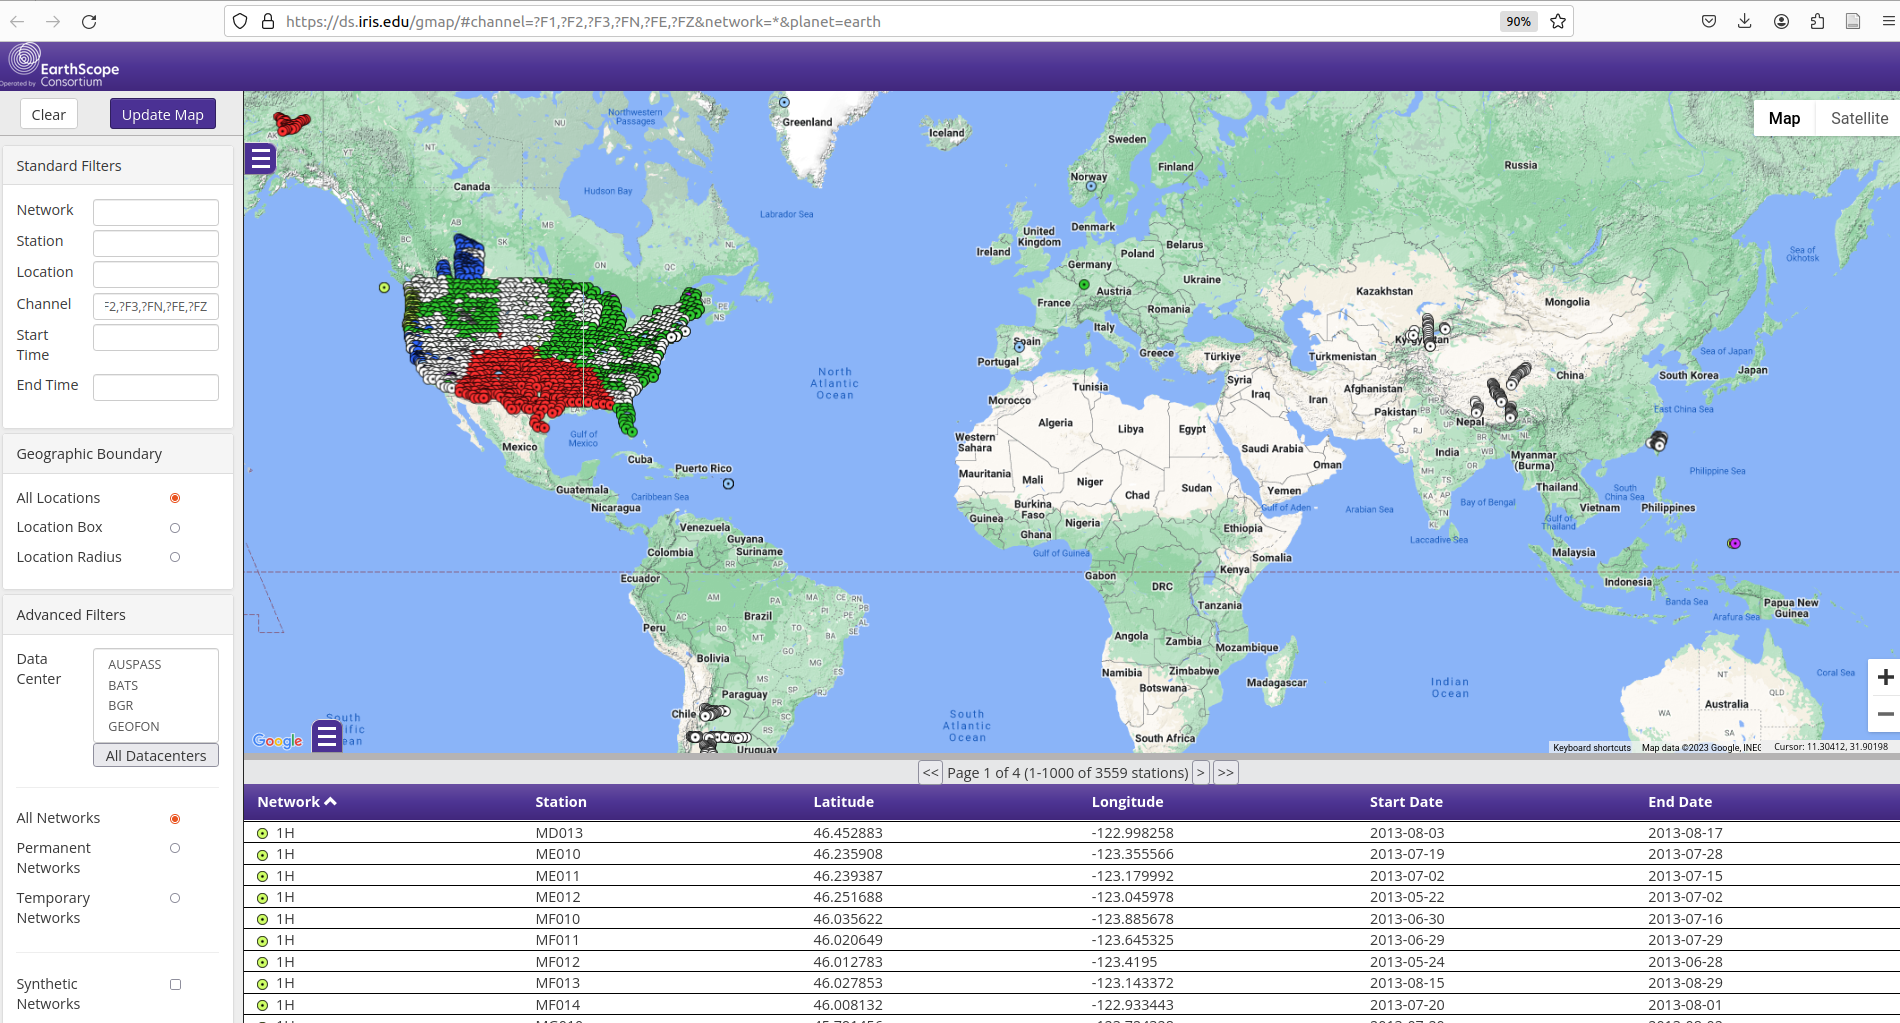


### Figure 2: Spatial distribution of the EarthScope magnetic dataset

Global data coverage returned from a query restricted only to magnetometer data.

## Exploring Metadata Availability Programatically With Queries

### Station Service

Below are some code examples for programatically generating URLs for exploring metadata availability.  All the qureries use the same base URL "http://service.iris.edu/fdsnws".  For more detailed examples of generating URLs from queries see the Earthscope [URL Builder](http://service.iris.edu/fdsnws/station/docs/1/builder/) website.

Here is an example of a URL that lists metadata for all stations and channels with magnetic field data:

In [4]:
# Specify the base URL  
fdsn_URL = "http://service.iris.edu/fdsnws"

# magnetic query using seed conventions
channels=['?FE', '?FN', '?FZ','?F1','?F2', '?F3', ]
channels = ','.join(channels)


# To obtain a list of all stations available:
channel_list_URL=f"{fdsn_URL}/station/1/query?cha={channels}&level=channel&format=text&includecomments=true&nodata=204"
print(f"channel_list_URL: {channel_list_URL}")

channel_list_URL: http://service.iris.edu/fdsnws/station/1/query?cha=?FE,?FN,?FZ,?F1,?F2,?F3&level=channel&format=text&includecomments=true&nodata=204


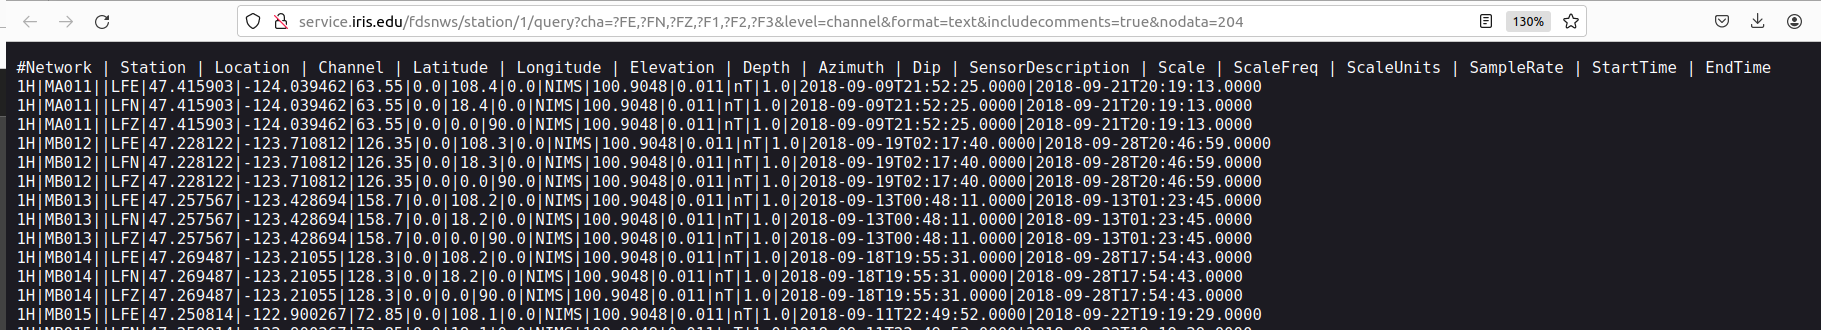

### Figure 3: Screengrab of station list associated with magnetic field data.  

As of December 2023, this webpage has 13228 lines!

### Availability Service

Note that each station is associated with a "Network" two-character code (first column in Figure above).  We can specify a network and see detail about the stations associated with this network, if we want to explore data availability via tabular summaries instead of using the map.  

Below is a code snippet for accessing a data coverage  (\"availability\") list for network "4P".

In [5]:
network = "4P"
channels_str = f"{channels}"
print(channels_str.replace(" ",""))
channel_URL = f"{fdsn_URL}/availability/1/query?format=text&net={network}&cha={channels}&orderby=nslc_time_quality_samplerate&includerestricted=False&nodata=204" 
print(f"channel_URL:\n {channel_URL}")

?FE,?FN,?FZ,?F1,?F2,?F3
channel_URL:
 http://service.iris.edu/fdsnws/availability/1/query?format=text&net=4P&cha=?FE,?FN,?FZ,?F1,?F2,?F3&orderby=nslc_time_quality_samplerate&includerestricted=False&nodata=204


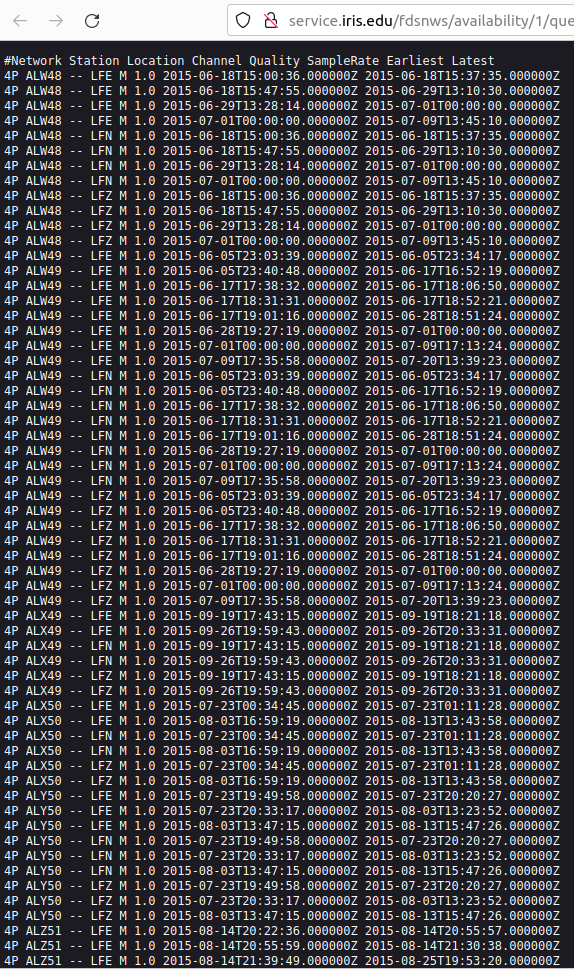

### Figure 4: Screengrab of availability URL for Network="4P"

### Metadata Aggregator (MDA)

Besides the tools described above, the Earthscope collection can be navigated heirarchically via the Metadata Aggregator [(MDA)](http://ds.iris.edu/mda/)
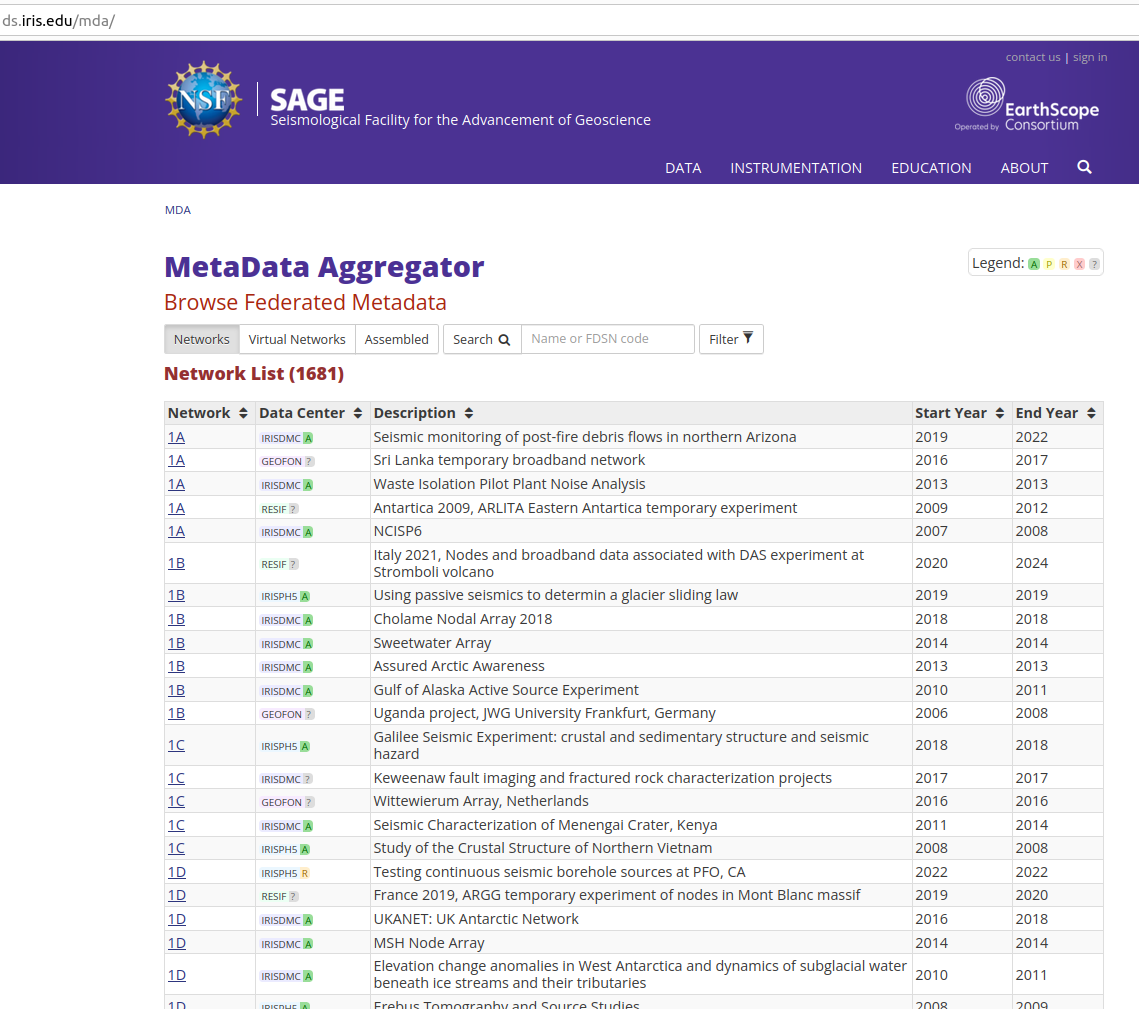


### Figure 5: Earthscope Metadata Aggregator (MDA) website landing page.

# 2. Case Study: 
### Comparison with Published Observation (Heyns et al 2020)

Here we will try to extract some magnetic field data and compare with published values.

Lets use this manuscript https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020SW002557

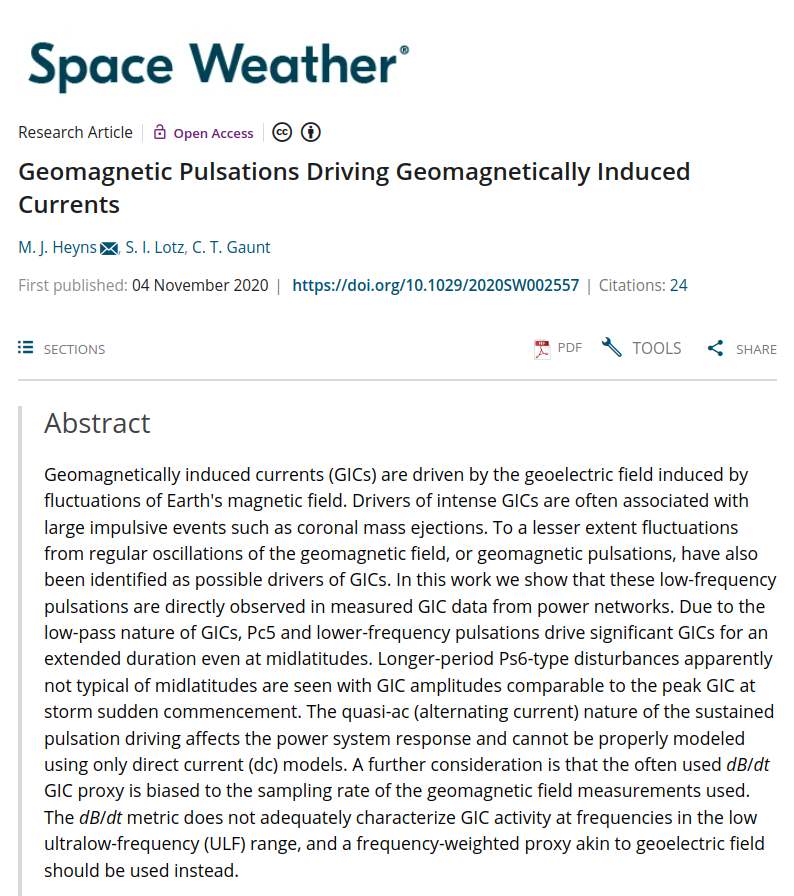

### Figure 6: Title and Abstract from Heyns et al. 2020

Figure 1 from the above paper shows an image of a magnetic field time series.

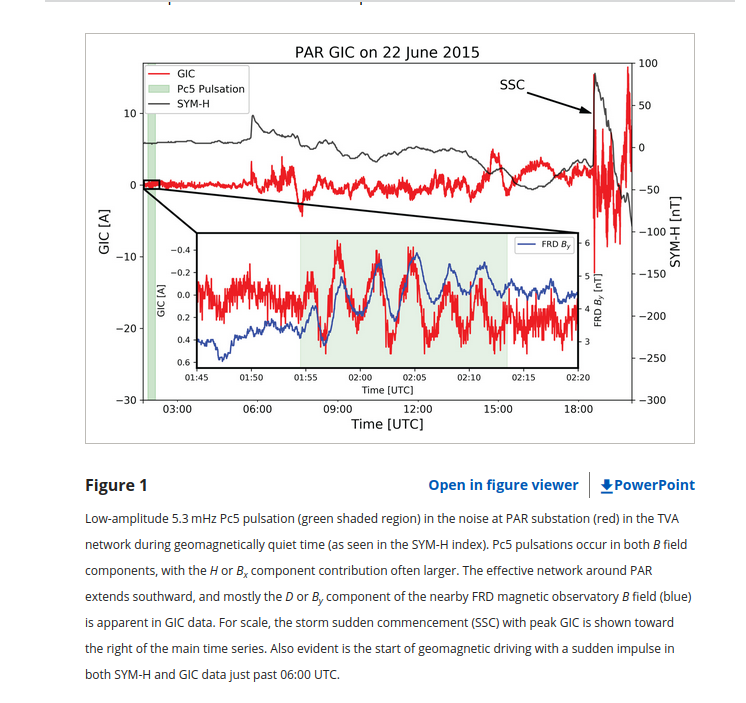

### Figure 7: Screengrab of Figure 1 from Heyns et al. 2020
Note that the inset in the lower panel shows 35 minutes of data from the USGS FRD observatory, component B_y.  This is the data we will examine.

We may be curious if other nearby stations also recorded the same fluctuations in the ambient magnetic field, which we will call the "event".  We can query the Earthscope data availability to see of other stations were recoding during this time interval.

##  Identify relevant stations

We could download data from FRD by using intermagnet, or the MTH5 extension for global geomagnetic observatories but lets use an EarthScope station instead.

The USGS website gives us the coordinates for FRD (near Fredricksburg VA):

https://www.usgs.gov/programs/geomagnetism/science/fredericksburg-frd

Station Id: FRD

Location: Corbin, VA

Latitude: 38.2047°N

Longitude: 77.3729°W

- First, we get virginia on the map and center it (to the right because there are not many observatories in the Atlantic Ocean), then we enter a date range around that the day of interest:
[2015-06-01, 2015-06-30]
- Several search methods are available to put a geographic boundary on that search such as using a bounding box or a radius.  Below is an example using "bounding box".
- Add ~5 degrees latitude and ~10 degees longitude around FRD to make a bounding box.

**Note that Earthscope uses negative longitudes**  To learn about this convetion and conversions, see this [webpage from NASA](https://ccmc.gsfc.nasa.gov/requests/instant/ranges.php)

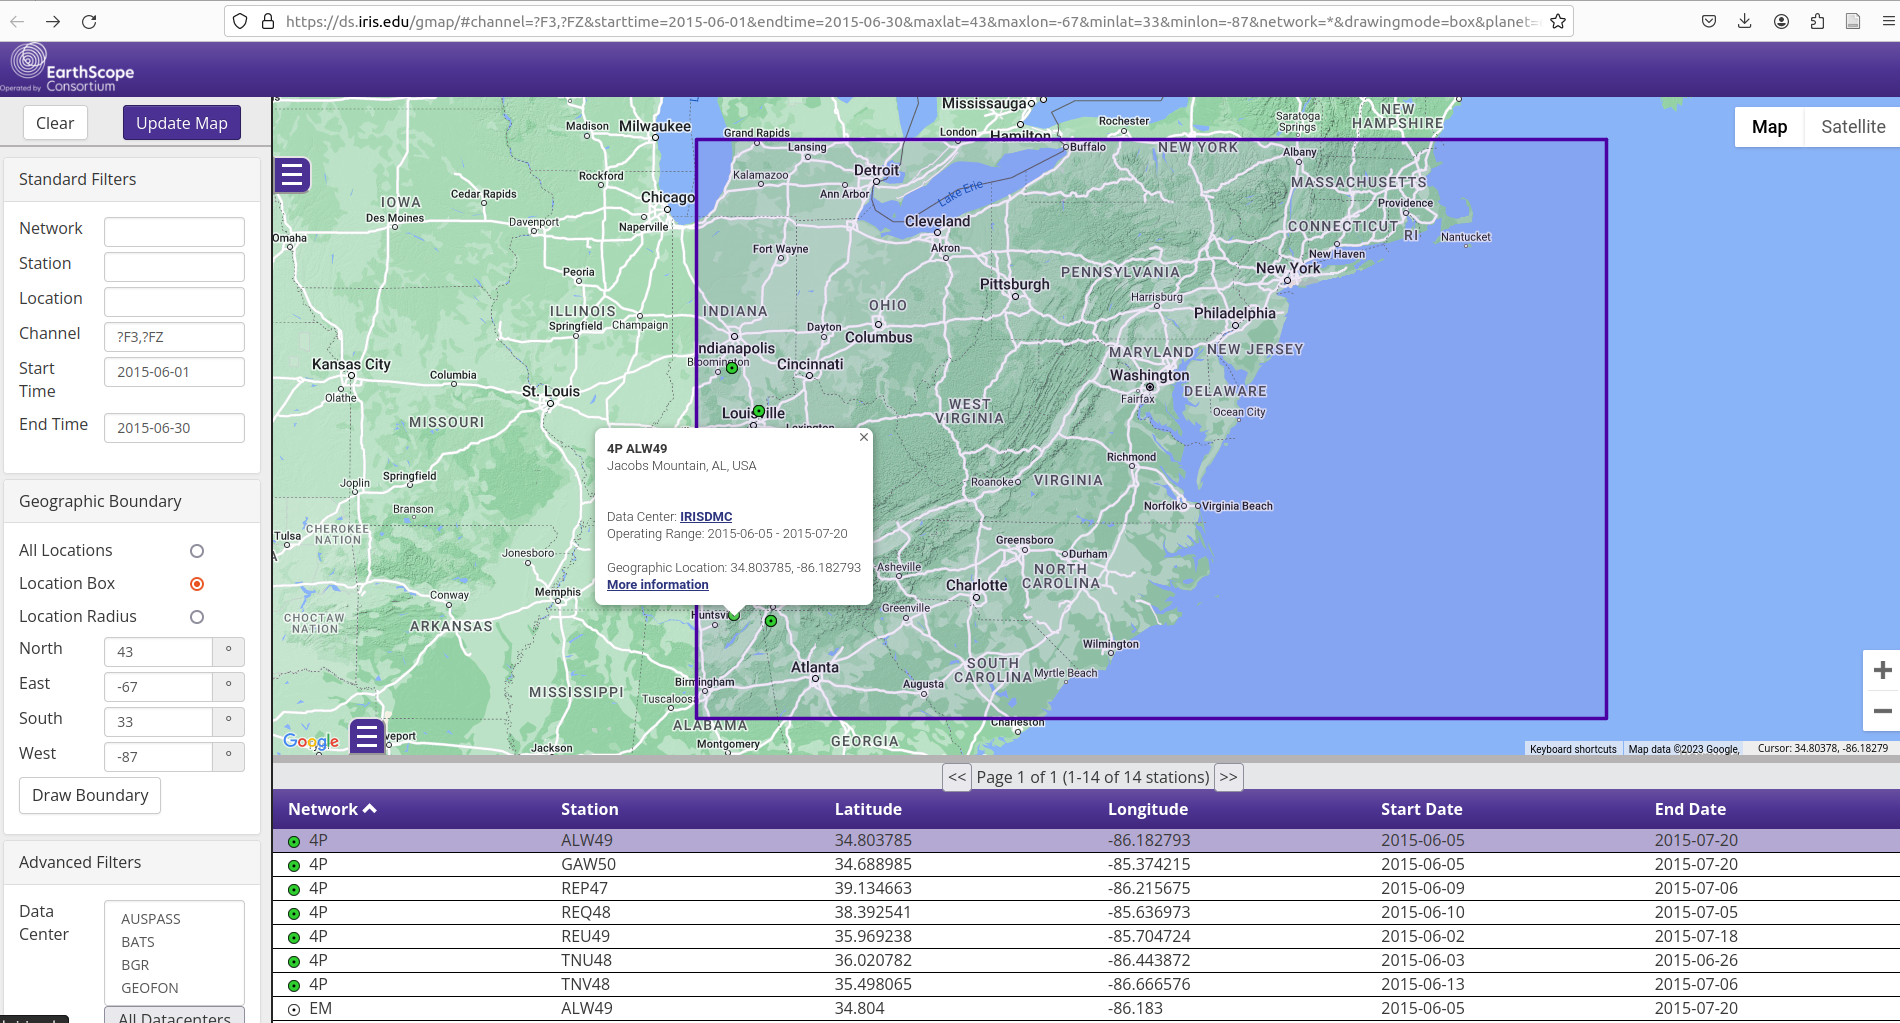

### Figure 8  Interactive map showing query results.  

Stations are shown with markers within the bounding box.  Stations are tabulated below the map (and the list is scrollable).  Clicking on a station marker makes a pop-up box, such as that shown for 4P ALW49.

### Select a single station

Let's pick the first one in alphabetical order.  Using the map we can readily see that there are metadata available in our time range, though we need to make sure that there is also data for the period.  Clicking a station makes a pop-up info box appear with further detail about the stations operating time range, and location.  Clicking on "more information" in this box takes us to the metadata aggregator (MDA) page, as shown below:


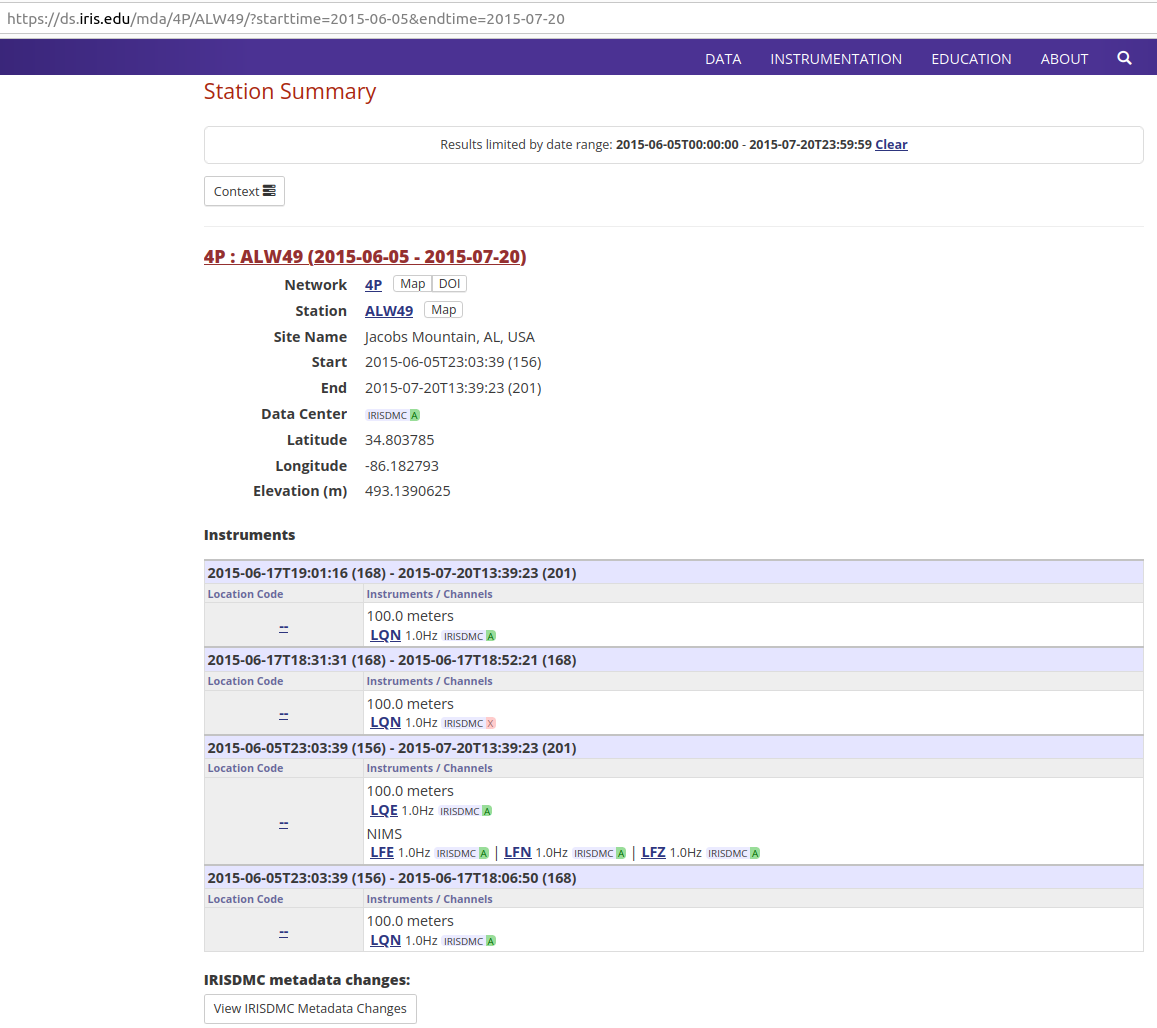

### Figure 9 MDA info about station ALW49

In [6]:
# define the station
station = "ALW49"
# station = "TNU48"

# We can also query availability for a stion restrict availability by station:
station_availability_URL = f"{fdsn_URL}/availability/1/query?format=text&net={network}&sta={station}&cha={channels}&orderby=nslc_time_quality_samplerate&includerestricted=False&nodata=204" 
print(f"station_availability_URL: {station_availability_URL}")

station_availability_URL: http://service.iris.edu/fdsnws/availability/1/query?format=text&net=4P&sta=ALW49&cha=?FE,?FN,?FZ,?F1,?F2,?F3&orderby=nslc_time_quality_samplerate&includerestricted=False&nodata=204


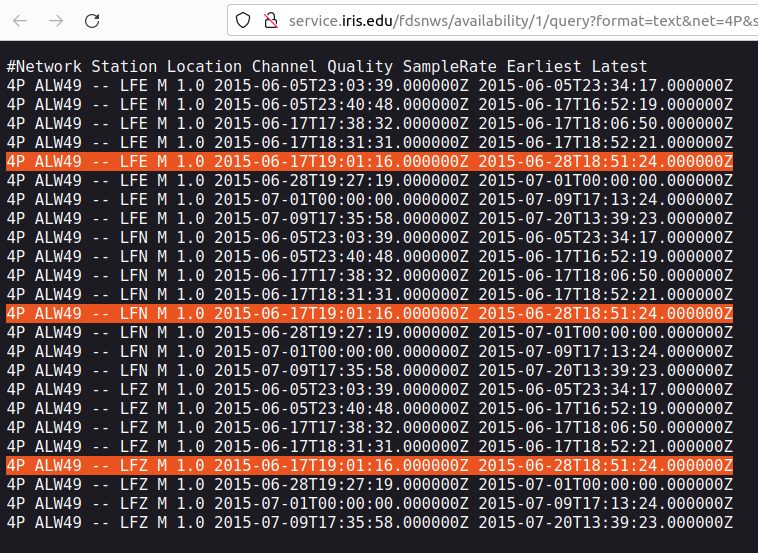

### Figure 10: 4P.ALW49 Data Availability

Results of programatically building URL to see availability of station ALW49. Note that there are several data acquisition "runs" in the list.  You can choose the relevant one(s) or just request the entire time interval, depending on your application.  In this case we are interested in data on June 22, 2015, and we can see (highlighted rows) that all 3 channels were reporting data coverage for that time interval.

# 3. Define request dataframe

MTH5 provides an interface to download time series from FDSN clients.  The data requests are structured in tabular format, with one row for each requested time series.  The columns of the table are listed below:

In [7]:
fdsn =FDSN()
fdsn.request_columns

['network', 'station', 'location', 'channel', 'start', 'end']

The request tables can be prepared as .csv or can be programatically generated as a pandas DataFrame.

Below is an example of building a request dataframe.  For start and end times, you can choose only the data of interest, or you can choose a larger interval to build the archive locally for later analysis. 

In the folowing example we first access the metadata from Earthscope and inspect it before requesting the data.  

Note:
- As seen in Figure 10 above, the location field for this data is not defined, so we just set the location column of the request dataframe to the empty string: ""
- When analysing short duration time intervals of data (short w.r.t. the duration of the entire data stream) such as in this case, where we are interested in around 35 minutes of data from a multiweek datastream, it is desireable if the requested data are longer than the data to be analysed.  This is because the data calibration is done in frequency domain, and there can be artefacts of the FFT/IFFT at the edges of the time series.  By padding the time interval of interest with data to either side you can ameliorate any such artefacts.

In [8]:
# Define the time interval of interest for future reference
time_interval_of_interest_start = "2015-06-22T01:45:00"
time_interval_of_interest_end = "2015-06-22T02:20:00"

In [9]:
# Generate data frame telling FDSN data provided 
# Network, Station, Location, Channel, Startime, Endtime codes of interest
network = "4P"
channels = [ "LFE", "LFN", "LFZ", ]

# ALW49 RUN BOUNDS
if station == "ALW49":
    start = '2015-06-17T19:01:16'
    end = '2015-07-28T18:51:24'
    #start = time_interval_of_interest_start
    #end = time_interval_of_interest_end
elif station == "TNU48":
    start = '2015-06-14T15:13:54.000000Z'
    end = '2015-06-26T17:53:14.000000Z'
else:
    start = '2015-06-01T12:00:00'
    end = '2015-07-01T12:00:00'

request_list = []
for channel in channels:
    request = [network, station, "", channel, start, end]
    request_list.append(request)

print(f"Request List \n {request_list}")

# Turn list into dataframe
metadata_request_df = pd.DataFrame(request_list, columns=fdsn.request_columns)

# Optionally save to a csv:
metadata_request_df.to_csv(f"{station}_request.csv", index=False)

print(f"\n\n metadata_request_df \n ")
metadata_request_df

Request List 
 [['4P', 'ALW49', '', 'LFE', '2015-06-17T19:01:16', '2015-07-28T18:51:24'], ['4P', 'ALW49', '', 'LFN', '2015-06-17T19:01:16', '2015-07-28T18:51:24'], ['4P', 'ALW49', '', 'LFZ', '2015-06-17T19:01:16', '2015-07-28T18:51:24']]


 metadata_request_df 
 


network station location channel                start                  end
0      4P   ALW49              LFE  2015-06-17T19:01:16  2015-07-28T18:51:24
1      4P   ALW49              LFN  2015-06-17T19:01:16  2015-07-28T18:51:24
2      4P   ALW49              LFZ  2015-06-17T19:01:16  2015-07-28T18:51:24

# 4. Build MTH5 
### (metadata only)

This has already been outlined in the MTH5 documentation, and the following is based on an [example in MTH5 for station CAS04](https://github.com/kujaku11/mth5/blob/master/docs/examples/notebooks/make_mth5_driver_v0.2.0.ipynb)

We start by building an inventory from the metadata.  The inventory is an obspy object, but an mt_metadata "experiment" object is the equivalent representation as shown below.  It is good practice to first inspect the experiment to verify the data availability.

In [10]:
inventory, traces = fdsn.get_inventory_from_df(metadata_request_df, data=False)
translator = XMLInventoryMTExperiment()
experiment = translator.xml_to_mt(inventory_object=inventory)

In [11]:
inventory

Inventory created at 2024-02-18T17:58:28.773323Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: MTH5
	Contains:
		Networks (1):
			4P
		Stations (1):
			4P.ALW49 (Jacobs Mountain, AL, USA)
		Channels (3):
			4P.ALW49..LFZ, 4P.ALW49..LFN, 4P.ALW49..LFE

The inventory can be explrored using the tools in obspy, but here we use the MTH5 container, the "experiment".  The MTH5 uses a hierarchy that is analagous to FDSN, but with some differences.  These will not be discussed in detail, but the important points are:

1. MTH5 has a "survey" level, which is similar to FDSN's top-level "network"
2. MTH5 has one level above "survey", the "experiment", which allows for the mixing of multiple networks in a single archive.

In [12]:
experiment

Experiment Contents
--------------------
Number of Surveys: 1
  Survey ID: Transportable Array
  Number of Stations: 1
  Number of Filters: 5
  --------------------
    Filter Name: magnetic_butterworth_low_pass
    Filter Type: zpk
    --------------------
    Filter Name: magnetic_analog_to_digital
    Filter Type: coefficient
    --------------------
    Filter Name: hy_time_offset
    Filter Type: time delay
    --------------------
    Filter Name: hx_time_offset
    Filter Type: time delay
    --------------------
    Filter Name: hz_time_offset
    Filter Type: time delay
    --------------------
    Station ID: ALW49
    Number of Runs: 7
    --------------------
      Run ID: a
      Number of Channels: 3
      Recorded Channels: hy, hx, hz
      Start: 2015-06-05T23:03:39+00:00
      End:   2015-06-05T23:34:17+00:00
      --------------------
      Run ID: b
      Number of Channels: 3
      Recorded Channels: hy, hx, hz
      Start: 2015-06-05T23:40:48+00:00
      End:   201

Note that we only specified a short time interval of interest but the experiment (and its inventory parent) have  information about the entire station history.

### Tabulated Metadata

We can optionally build a "dataless" mth5 from this inventory.  The dataless MTH5 can be useful because it provides programmatic access to a summary of the available data in a pandas DataFrame as shown below:

In [13]:
# Initialize an mth5 container, packing the metadata contained in "experiment" variable
h5_path = "tmp.h5"
mth5_obj = initialize_mth5(h5_path, mode="w") # mode="a" allows you to aggregate results
mth5_obj.from_experiment(experiment)
mth5_obj.channel_summary.summarize()

summary_df = mth5_obj.channel_summary.to_dataframe()
summary_df

2024-02-18T09:58:29.729337-0800 | WARNING | mth5.utils.helpers | initialize_mth5 | File tmp.h5 exists, removing from file system.
 closing all open h5 files before removal
2024-02-18T09:58:30.076350-0800 | INFO | mth5.mth5 | _initialize_file | Initialized MTH5 0.1.0 file tmp.h5 in mode w


survey station run   latitude  longitude   elevation  \
0   Transportable Array   ALW49   a  34.803785 -86.182793  493.139063   
1   Transportable Array   ALW49   a  34.803785 -86.182793  493.139063   
2   Transportable Array   ALW49   a  34.803785 -86.182793  493.139063   
3   Transportable Array   ALW49   b  34.803785 -86.182793  493.139063   
4   Transportable Array   ALW49   b  34.803785 -86.182793  493.139063   
5   Transportable Array   ALW49   b  34.803785 -86.182793  493.139063   
6   Transportable Array   ALW49   c  34.803785 -86.182793  493.139063   
7   Transportable Array   ALW49   c  34.803785 -86.182793  493.139063   
8   Transportable Array   ALW49   c  34.803785 -86.182793  493.139063   
9   Transportable Array   ALW49   d  34.803785 -86.182793  493.139063   
10  Transportable Array   ALW49   d  34.803785 -86.182793  493.139063   
11  Transportable Array   ALW49   d  34.803785 -86.182793  493.139063   
12  Transportable Array   ALW49   e  34.803785 -86.182793  493.139063   
13  Transportable Array   ALW49   e  34.803785 -86.182793  493.139063   
14  Transportable Array   ALW49   e  34.803785 -86.182793  493.139063   
15  Transportable Array   ALW49   f  34.803785 -86.182793  493.139063   
16  Transportable Array   ALW49   f  34.803785 -86.182793  493.139063   
17  Transportable Array   ALW49   f  34.803785 -86.182793  493.139063   
18  Transportable Array   ALW49   g  34.803785 -86.182793  493.139063   
19  Transportable Array   ALW49   g  34.803785 -86.182793  493.139063   
20  Transportable Array   ALW49   g  34.803785 -86.182793  493.139063   

   component                     start                       end  n_samples  \
0         hx 2015-06-05 23:03:39+00:00 2015-06-05 23:34:17+00:00       1838   
1         hy 2015-06-05 23:03:39+00:00 2015-06-05 23:34:17+00:00       1838   
2         hz 2015-06-05 23:03:39+00:00 2015-06-05 23:34:17+00:00       1838   
3         hx 2015-06-05 23:40:48+00:00 2015-06-17 16:52:19+00:00    1012291   
4         hy 2015-06-05 23:40:48+00:00 2015-06-17 16:52:19+00:00    1012291   
5         hz 2015-06-05 23:40:48+00:00 2015-06-17 16:52:19+00:00    1012291   
6         hx 2015-06-17 17:38:32+00:00 2015-06-17 18:06:50+00:00       1698   
7         hy 2015-06-17 17:38:32+00:00 2015-06-17 18:06:50+00:00       1698   
8         hz 2015-06-17 17:38:32+00:00 2015-06-17 18:06:50+00:00       1698   
9         hx 2015-06-17 18:31:31+00:00 2015-06-17 18:52:21+00:00       1250   
10        hy 2015-06-17 18:31:31+00:00 2015-06-17 18:52:21+00:00       1250   
11        hz 2015-06-17 18:31:31+00:00 2015-06-17 18:52:21+00:00       1250   
12        hx 2015-06-17 19:01:16+00:00 2015-06-28 18:51:24+00:00     949808   
13        hy 2015-06-17 19:01:16+00:00 2015-06-28 18:51:24+00:00     949808   
14        hz 2015-06-17 19:01:16+00:00 2015-06-28 18:51:24+00:00     949808   
15        hx 2015-06-28 19:27:19+00:00 2015-07-09 17:13:24+00:00     942365   
16        hy 2015-06-28 19:27:19+00:00 2015-07-09 17:13:24+00:00     942365   
17        hz 2015-06-28 19:27:19+00:00 2015-07-09 17:13:24+00:00     942365   
18        hx 2015-07-09 17:35:58+00:00 2015-07-20 13:39:23+00:00     936205   
19        hy 2015-07-09 17:35:58+00:00 2015-07-20 13:39:23+00:00     936205   
20        hz 2015-07-09 17:35:58+00:00 2015-07-20 13:39:23+00:00     936205   

    sample_rate measurement_type  azimuth  tilt           units  \
0           1.0         magnetic    357.1   0.0  digital counts   
1           1.0         magnetic     87.1   0.0  digital counts   
2           1.0         magnetic      0.0  90.0  digital counts   
3           1.0         magnetic    357.1   0.0  digital counts   
4           1.0         magnetic     87.1   0.0  digital counts   
5           1.0         magnetic      0.0  90.0  digital counts   
6           1.0         magnetic    357.1   0.0  digital counts   
7           1.0         magnetic     87.1   0.0  digital counts   
8           1.0         magnetic      0.0  90.0  digital counts   
9

The channel summary provides a complete list of available data split into "Runs" -- contiguous blocks of available data for a particular channel.

This information can be a little dense as the archives grow ... You can look at a lower density form of data availability in the HDF5 file several ways. 

One way is to access the "run_summary" method of the "Station" group within the mth5 as shown in the snippet below:


In [14]:
print(type(mth5_obj.stations_group))
mth5_obj.stations_group.station_summary

<class 'mth5.groups.station.MasterStationGroup'>


station                     start                       end   latitude  \
0   ALW49 2015-06-05 23:03:39+00:00 2015-07-20 13:39:23+00:00  34.803785   

   longitude  
0 -86.182793

In [15]:
station_obj = mth5_obj.get_station("ALW49")
station_obj.run_summary


id               start                 end components measurement_type  \
0  a 2015-06-05 23:03:39 2015-06-05 23:34:17   hx,hy,hz           BB, LP   
1  b 2015-06-05 23:40:48 2015-06-17 16:52:19   hx,hy,hz           BB, LP   
2  c 2015-06-17 17:38:32 2015-06-17 18:06:50   hx,hy,hz           BB, LP   
3  d 2015-06-17 18:31:31 2015-06-17 18:52:21   hx,hy,hz           BB, LP   
4  e 2015-06-17 19:01:16 2015-06-28 18:51:24   hx,hy,hz           BB, LP   
5  f 2015-06-28 19:27:19 2015-07-09 17:13:24   hx,hy,hz           BB, LP   
6  g 2015-07-09 17:35:58 2015-07-20 13:39:23   hx,hy,hz           BB, LP   

   sample_rate           hdf5_reference  
0          1.0  <HDF5 object reference>  
1          1.0  <HDF5 object reference>  
2          1.0  <HDF5 object reference>  
3          1.0  <HDF5 object reference>  
4          1.0  <HDF5 object reference>  
5          1.0  <HDF5 object reference>  
6          1.0  <HDF5 object reference>

Now we can see the time intervals available in a neat table, and we can also make a copy of this table and operate on it if we like. 
Here is an example snippet showing how to isolate the run containing the time interval of interest from the run summary:


In [16]:
run_summary_df = station_obj.run_summary.copy(deep=True)


In [17]:
run_summary_df["duration"] = run_summary_df["end"] - run_summary_df["start"]
run_summary_df

id               start                 end components measurement_type  \
0  a 2015-06-05 23:03:39 2015-06-05 23:34:17   hx,hy,hz           BB, LP   
1  b 2015-06-05 23:40:48 2015-06-17 16:52:19   hx,hy,hz           BB, LP   
2  c 2015-06-17 17:38:32 2015-06-17 18:06:50   hx,hy,hz           BB, LP   
3  d 2015-06-17 18:31:31 2015-06-17 18:52:21   hx,hy,hz           BB, LP   
4  e 2015-06-17 19:01:16 2015-06-28 18:51:24   hx,hy,hz           BB, LP   
5  f 2015-06-28 19:27:19 2015-07-09 17:13:24   hx,hy,hz           BB, LP   
6  g 2015-07-09 17:35:58 2015-07-20 13:39:23   hx,hy,hz           BB, LP   

   sample_rate           hdf5_reference         duration  
0          1.0  <HDF5 object reference>  0 days 00:30:38  
1          1.0  <HDF5 object reference> 11 days 17:11:31  
2          1.0  <HDF5 object reference>  0 days 00:28:18  
3          1.0  <HDF5 object reference>  0 days 00:20:50  
4          1.0  <HDF5 object reference> 10 days 23:50:08  
5          1.0  <HDF5 object reference> 10 days 21:46:05  
6          1.0  <HDF5 object reference> 10 days 20:03:25

In [18]:
cond1 = run_summary_df.start<pd.Timestamp(time_interval_of_interest_start)
cond2 = run_summary_df.end>pd.Timestamp(time_interval_of_interest_end)

run_of_interest = run_summary_df[cond1 & cond2]
run_of_interest

id               start                 end components measurement_type  \
4  e 2015-06-17 19:01:16 2015-06-28 18:51:24   hx,hy,hz           BB, LP   

   sample_rate           hdf5_reference         duration  
4          1.0  <HDF5 object reference> 10 days 23:50:08

If the time period of interest fits inside a contiguous run, we can filter that row as above

# 5. Build MTH5 (with data)

Get the data for this run pulled down to our local machine

In [19]:
client = "IRIS"
mth5_version = "0.1.0" 
# mth5_version = "0.2.0"
interact = False

maker = MakeMTH5(mth5_version=mth5_version, client=client)
maker.client = client

In [20]:
metadata_request_df

network station location channel                start                  end
0      4P   ALW49              LFE  2015-06-17T19:01:16  2015-07-28T18:51:24
1      4P   ALW49              LFN  2015-06-17T19:01:16  2015-07-28T18:51:24
2      4P   ALW49              LFZ  2015-06-17T19:01:16  2015-07-28T18:51:24

In [21]:
# A channel summary can be transformed into a request dataframe for the specific runs of interest
# but you would need to install aurora for this
# from aurora.sandbox.mth5_channel_summary_helpers import channel_summary_to_make_mth5
# active_runs = ["b", ]
# if active_runs:
#    summary_df = summary_df[summary_df["run"].isin(active_runs)]  # summary_df[0:5]
# data_request_df = channel_summary_to_make_mth5(summary_df, network=network, verbose=True)

data_request_df = metadata_request_df.copy(deep=True)
data_request_df.start = run_of_interest.iloc[0].start
data_request_df.end = run_of_interest.iloc[0].end

In [22]:
data_request_df.to_csv(f"{station}_request.csv", index=False)

In [23]:
data_request_df

network station location channel               start                 end
0      4P   ALW49              LFE 2015-06-17 19:01:16 2015-06-28 18:51:24
1      4P   ALW49              LFN 2015-06-17 19:01:16 2015-06-28 18:51:24
2      4P   ALW49              LFZ 2015-06-17 19:01:16 2015-06-28 18:51:24

In [24]:
mth5_obj = maker.from_fdsn_client(data_request_df, path="", interact=interact)
if interact:
    mth5_path = mth5_obj.filename
else:
    mth5_path = mth5_obj
print(f"Made MTH5 at {mth5_path}")

2024-02-18T09:58:30.872110-0800 | WARNING | mth5.mth5 | open_mth5 | 4P_ALW49.h5 will be overwritten in 'w' mode
2024-02-18T09:58:31.155219-0800 | INFO | mth5.mth5 | _initialize_file | Initialized MTH5 0.1.0 file /home/kkappler/software/irismt/aurora/docs/examples/4P_ALW49.h5 in mode w
2024-02-18T09:58:39.337440-0800 | WARNING | mth5.clients.fdsn | wrangle_runs_into_containers | More or less runs have been requested by the user than are defined in the metadata. Runs will be defined but only the requested run extents contain time series data based on the users request.
2024-02-18T09:58:39.351449-0800 | INFO | mth5.groups.base | _add_group | RunGroup a already exists, returning existing group.
2024-02-18T09:58:39.387386-0800 | INFO | mth5.groups.base | _add_group | RunGroup b already exists, returning existing group.
2024-02-18T09:58:39.419352-0800 | INFO | mth5.groups.base | _add_group | RunGroup c already exists, returning existing group.
2024-02-18T09:58:39.451092-0800 | INFO | mth5.gr

In [25]:
m = MTH5()

In [26]:
m.open_mth5(mth5_path)

/:
    |- Group: Survey
    ----------------
        |- Group: Filters
        -----------------
            |- Group: coefficient
            ---------------------
                |- Group: magnetic_analog_to_digital
                ------------------------------------
            |- Group: fap
            -------------
            |- Group: fir
            -------------
            |- Group: time_delay
            --------------------
                |- Group: hx_time_offset
                ------------------------
                |- Group: hy_time_offset
                ------------------------
                |- Group: hz_time_offset
                ------------------------
            |- Group: zpk
            -------------
                |- Group: magnetic_butterworth_low_pass
                ---------------------------------------
                    --> Dataset: poles
                    ....................
                    --> Dataset: zeros
                    ..........

In [27]:
channel_summary_df = m.channel_summary.to_dataframe()
channel_summary_df

survey station run   latitude  longitude   elevation  \
0   Transportable Array   ALW49   a  34.803785 -86.182793  493.139063   
1   Transportable Array   ALW49   a  34.803785 -86.182793  493.139063   
2   Transportable Array   ALW49   a  34.803785 -86.182793  493.139063   
3   Transportable Array   ALW49   b  34.803785 -86.182793  493.139063   
4   Transportable Array   ALW49   b  34.803785 -86.182793  493.139063   
5   Transportable Array   ALW49   b  34.803785 -86.182793  493.139063   
6   Transportable Array   ALW49   c  34.803785 -86.182793  493.139063   
7   Transportable Array   ALW49   c  34.803785 -86.182793  493.139063   
8   Transportable Array   ALW49   c  34.803785 -86.182793  493.139063   
9   Transportable Array   ALW49   d  34.803785 -86.182793  493.139063   
10  Transportable Array   ALW49   d  34.803785 -86.182793  493.139063   
11  Transportable Array   ALW49   d  34.803785 -86.182793  493.139063   
12  Transportable Array   ALW49   e  34.803785 -86.182793  493.139063   
13  Transportable Array   ALW49   e  34.803785 -86.182793  493.139063   
14  Transportable Array   ALW49   e  34.803785 -86.182793  493.139063   
15  Transportable Array   ALW49   f  34.803785 -86.182793  493.139063   
16  Transportable Array   ALW49   f  34.803785 -86.182793  493.139063   
17  Transportable Array   ALW49   f  34.803785 -86.182793  493.139063   
18  Transportable Array   ALW49   g  34.803785 -86.182793  493.139063   
19  Transportable Array   ALW49   g  34.803785 -86.182793  493.139063   
20  Transportable Array   ALW49   g  34.803785 -86.182793  493.139063   

   component                     start                       end  n_samples  \
0         hx 2015-06-05 23:03:39+00:00 2015-06-05 23:34:17+00:00       1838   
1         hy 2015-06-05 23:03:39+00:00 2015-06-05 23:34:17+00:00       1838   
2         hz 2015-06-05 23:03:39+00:00 2015-06-05 23:34:17+00:00       1838   
3         hx 2015-06-05 23:40:48+00:00 2015-06-17 16:52:19+00:00    1012291   
4         hy 2015-06-05 23:40:48+00:00 2015-06-17 16:52:19+00:00    1012291   
5         hz 2015-06-05 23:40:48+00:00 2015-06-17 16:52:19+00:00    1012291   
6         hx 2015-06-17 17:38:32+00:00 2015-06-17 18:06:50+00:00       1698   
7         hy 2015-06-17 17:38:32+00:00 2015-06-17 18:06:50+00:00       1698   
8         hz 2015-06-17 17:38:32+00:00 2015-06-17 18:06:50+00:00       1698   
9         hx 2015-06-17 18:31:31+00:00 2015-06-17 18:52:21+00:00       1250   
10        hy 2015-06-17 18:31:31+00:00 2015-06-17 18:52:21+00:00       1250   
11        hz 2015-06-17 18:31:31+00:00 2015-06-17 18:52:21+00:00       1250   
12        hx 2015-06-17 19:01:16+00:00 2015-06-28 18:51:24+00:00     949809   
13        hy 2015-06-17 19:01:16+00:00 2015-06-28 18:51:24+00:00     949809   
14        hz 2015-06-17 19:01:16+00:00 2015-06-28 18:51:24+00:00     949809   
15        hx 2015-06-28 19:27:19+00:00 2015-07-09 17:13:24+00:00     942365   
16        hy 2015-06-28 19:27:19+00:00 2015-07-09 17:13:24+00:00     942365   
17        hz 2015-06-28 19:27:19+00:00 2015-07-09 17:13:24+00:00     942365   
18        hx 2015-07-09 17:35:58+00:00 2015-07-20 13:39:23+00:00     936205   
19        hy 2015-07-09 17:35:58+00:00 2015-07-20 13:39:23+00:00     936205   
20        hz 2015-07-09 17:35:58+00:00 2015-07-20 13:39:23+00:00     936205   

    sample_rate measurement_type  azimuth  tilt           units  \
0           1.0         magnetic    357.1   0.0  digital counts   
1           1.0         magnetic     87.1   0.0  digital counts   
2           1.0         magnetic      0.0  90.0  digital counts   
3           1.0         magnetic    357.1   0.0  digital counts   
4           1.0         magnetic     87.1   0.0  digital counts   
5           1.0         magnetic      0.0  90.0  digital counts   
6           1.0         magnetic    357.1   0.0  digital counts   
7           1.0         magnetic     87.1   0.0  digital counts   
8           1.0         magnetic      0.0  90.0  digital counts   
9

You can now select the rows (12, 13, 14 zero-indexed) that contain the data of interest.  

The snippet below programatically accessed a sub-dataframe from the channel summary corresponding with the time interval of interest:

In [28]:
cond1 = channel_summary_df.start <pd.Timestamp(time_interval_of_interest_start).tz_localize("UTC")
cond2 = channel_summary_df.end >pd.Timestamp(time_interval_of_interest_end).tz_localize("UTC")

channels_of_interest = channel_summary_df[cond1 & cond2]
channels_of_interest

survey station run   latitude  longitude   elevation  \
12  Transportable Array   ALW49   e  34.803785 -86.182793  493.139063   
13  Transportable Array   ALW49   e  34.803785 -86.182793  493.139063   
14  Transportable Array   ALW49   e  34.803785 -86.182793  493.139063   

   component                     start                       end  n_samples  \
12        hx 2015-06-17 19:01:16+00:00 2015-06-28 18:51:24+00:00     949809   
13        hy 2015-06-17 19:01:16+00:00 2015-06-28 18:51:24+00:00     949809   
14        hz 2015-06-17 19:01:16+00:00 2015-06-28 18:51:24+00:00     949809   

    sample_rate measurement_type  azimuth  tilt           units  \
12          1.0         magnetic    357.1   0.0  digital counts   
13          1.0         magnetic     87.1   0.0  digital counts   
14          1.0         magnetic      0.0  90.0  digital counts   

             hdf5_reference       run_hdf5_reference   station_hdf5_reference  
12  <HDF5 object reference>  <HDF5 object reference>  <HDF5 object reference>  
13  <HDF5 object reference>  <HDF5 object reference>  <HDF5 object reference>  
14  <HDF5 object reference>  <HDF5 object reference>  <HDF5 object reference>

In [29]:
hx_index = channels_of_interest[channels_of_interest["component"] == "hx"].index[0]
hy_index = channels_of_interest[channels_of_interest["component"] == "hy"].index[0]
hz_index = channels_of_interest[channels_of_interest["component"] == "hz"].index[0]

We can point at the data by using the "hdf5_reference" column of the data frame, for example:

In [30]:
hx = m.from_reference(channel_summary_df.iloc[hx_index].hdf5_reference).to_channel_ts()
print(hx)

Channel Summary:
	Survey:       Transportable Array
	Station:      ALW49
	Run:          e
	Channel Type: Magnetic
	Component:    hx
	Sample Rate:  1.0
	Start:        2015-06-17T19:01:16+00:00
	End:          2015-06-28T18:51:24+00:00
	N Samples:    949809


And here we can see the channel metadata:

In [31]:
hx.channel_metadata

{
    "magnetic": {
        "channel_number": 0,
        "comments": "run_ids: [g,f,e,d,c,b,a]",
        "component": "hx",
        "data_quality.rating.value": 0,
        "filter.applied": [
            true,
            true,
            true
        ],
        "filter.name": [
            "magnetic_butterworth_low_pass",
            "magnetic_analog_to_digital",
            "hx_time_offset"
        ],
        "hdf5_reference": "<HDF5 object reference>",
        "location.elevation": 493.1,
        "location.latitude": 34.803785,
        "location.longitude": -86.182793,
        "measurement_azimuth": 357.1,
        "measurement_tilt": 0.0,
        "mth5_type": "Magnetic",
        "sample_rate": 1.0,
        "sensor.id": "2612-01",
        "sensor.manufacturer": "Barry Narod",
        "sensor.model": "fluxgate NIMS",
        "sensor.name": "NIMS",
        "sensor.type": "Magnetometer",
        "time_period.end": "2015-06-28T18:51:24+00:00",
        "time_period.start": "2015-06-17T19

# 6. Calibrating time series


And, if we are curious, the details of the filters that Earthscope has archived with the data 

In [32]:
print(hx.channel_response)

Filters Included:
pole_zero_filter:
	calibration_date = 1980-01-01
	comments = NIMS magnetic field 3 pole Butterworth 0.5 low pass (analog)
	gain = 1.0
	name = magnetic_butterworth_low_pass
	normalization_factor = 2002.26936395594
	poles = [ -6.283185+10.882477j  -6.283185-10.882477j -12.566371 +0.j      ]
	type = zpk
	units_in = nT
	units_out = V
	zeros = []
--------------------
coefficient_filter:
	calibration_date = 1980-01-01
	comments = analog to digital conversion (magnetic)
	gain = 100.0
	name = magnetic_analog_to_digital
	type = coefficient
	units_in = V
	units_out = count
--------------------
time_delay_filter:
	calibration_date = 1980-01-01
	comments = time offset in seconds (digital)
	delay = -0.192
	gain = 1.0
	name = hx_time_offset
	type = time delay
	units_in = count
	units_out = count
--------------------



The metadata taken from the server should be exmained to see if the filters are those in the station XML.   We can read from the output above the units of the various filters.  

**N.B. The archiving of data and metadata at Earthscope is experiencing continuous improvements.  For some historical data, the input and output units of the filter are not updated, and will show as "unknown".  In this case, we cannot calibrate the data into SI units without manual intervention.**

2024-02-18T09:58:40.748731-0800 | WARNING | mt_metadata.timeseries.filters.channel_response | complex_response | Filters list not provided, building list assuming all are applied


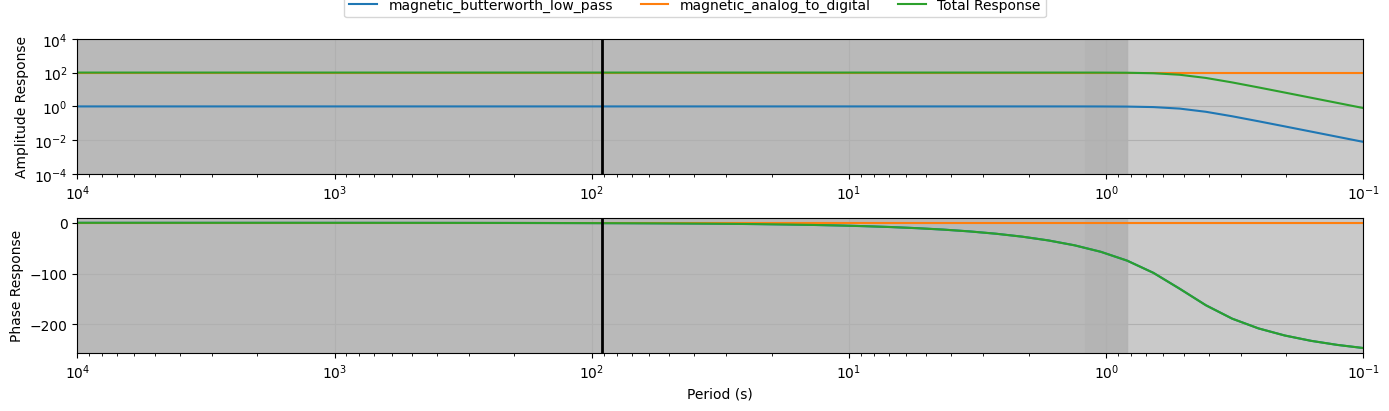

In [33]:
hx.channel_response.plot_response(np.logspace(-4, 1, 50))

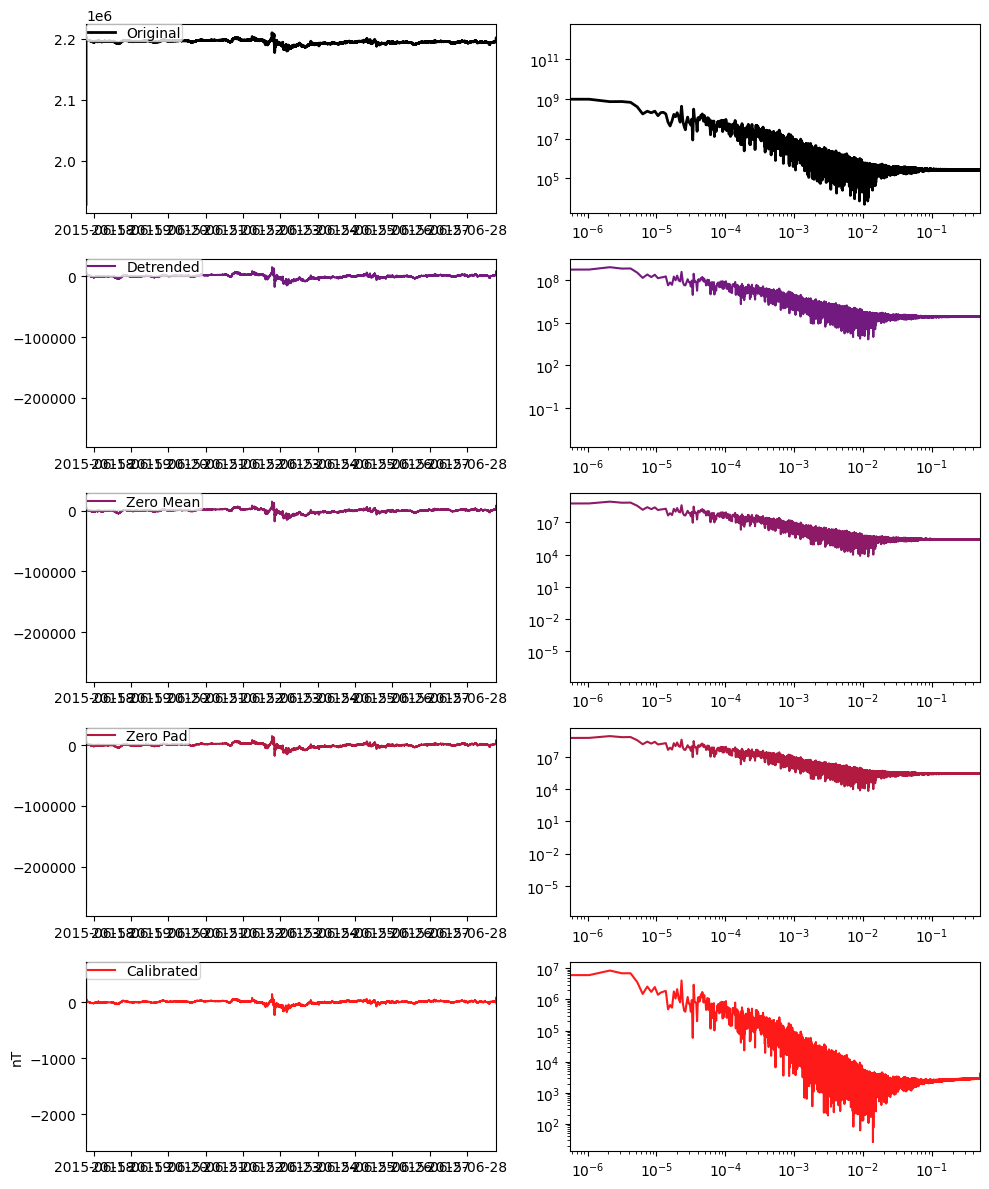

In [34]:
calibrated_hx = hx.remove_instrument_response(plot=True)

In [35]:
calibrated_hx.channel_metadata

{
    "magnetic": {
        "channel_number": 0,
        "comments": "run_ids: [g,f,e,d,c,b,a]",
        "component": "hx",
        "data_quality.rating.value": 0,
        "filter.applied": [
            false,
            false,
            true
        ],
        "filter.name": [
            "magnetic_butterworth_low_pass",
            "magnetic_analog_to_digital",
            "hx_time_offset"
        ],
        "hdf5_reference": "<HDF5 object reference>",
        "location.elevation": 493.1,
        "location.latitude": 34.803785,
        "location.longitude": -86.182793,
        "measurement_azimuth": 357.1,
        "measurement_tilt": 0.0,
        "mth5_type": "Magnetic",
        "sample_rate": 1.0,
        "sensor.id": "2612-01",
        "sensor.manufacturer": "Barry Narod",
        "sensor.model": "fluxgate NIMS",
        "sensor.name": "NIMS",
        "sensor.type": "Magnetometer",
        "time_period.end": "2015-06-28T18:51:24+00:00",
        "time_period.start": "2015-06-17T

Note that the channel metadata for calibrated_hx is subtly different that for hx.  The units were previously digital counts, but are now nanotesla, and the filter.applied booleans have flipped for the first two filters.  The third filter in this example is a sub-second time delay, and this is not applied by default.

The data associated with the calibrated ChannelTS can be accessed as follows:

In [36]:
hx_xrts = calibrated_hx.to_xarray()
hx_xrts

<xarray.DataArray 'hx' (time: 949809)>
array([-2496.29303964,   564.60031706,   295.59494239, ...,
         -11.17248495,   -14.78140548,   -21.48556597])
Coordinates:
  * time     (time) datetime64[ns] 2015-06-17T19:01:16 ... 2015-06-28T18:51:24
Attributes: (12/25)
    channel_number:             0
    comments:                   run_ids: [g,f,e,d,c,b,a]
    component:                  hx
    data_quality.rating.value:  0
    filter.applied:             [False, False, True]
    filter.name:                ['magnetic_butterworth_low_pass', 'magnetic_a...
    ...                         ...
    time_period.end:            2015-06-28T18:51:24+00:00
    time_period.start:          2015-06-17T19:01:16+00:00
    type:                       magnetic
    units:                      nanotesla
    station.id:                 ALW49
    run.id:                     e

Following the example above we can apply the same calibration to Hy and Hz

In [37]:
hy = m.from_reference(channel_summary_df.iloc[hy_index].hdf5_reference).to_channel_ts()
hz = m.from_reference(channel_summary_df.iloc[hz_index].hdf5_reference).to_channel_ts()

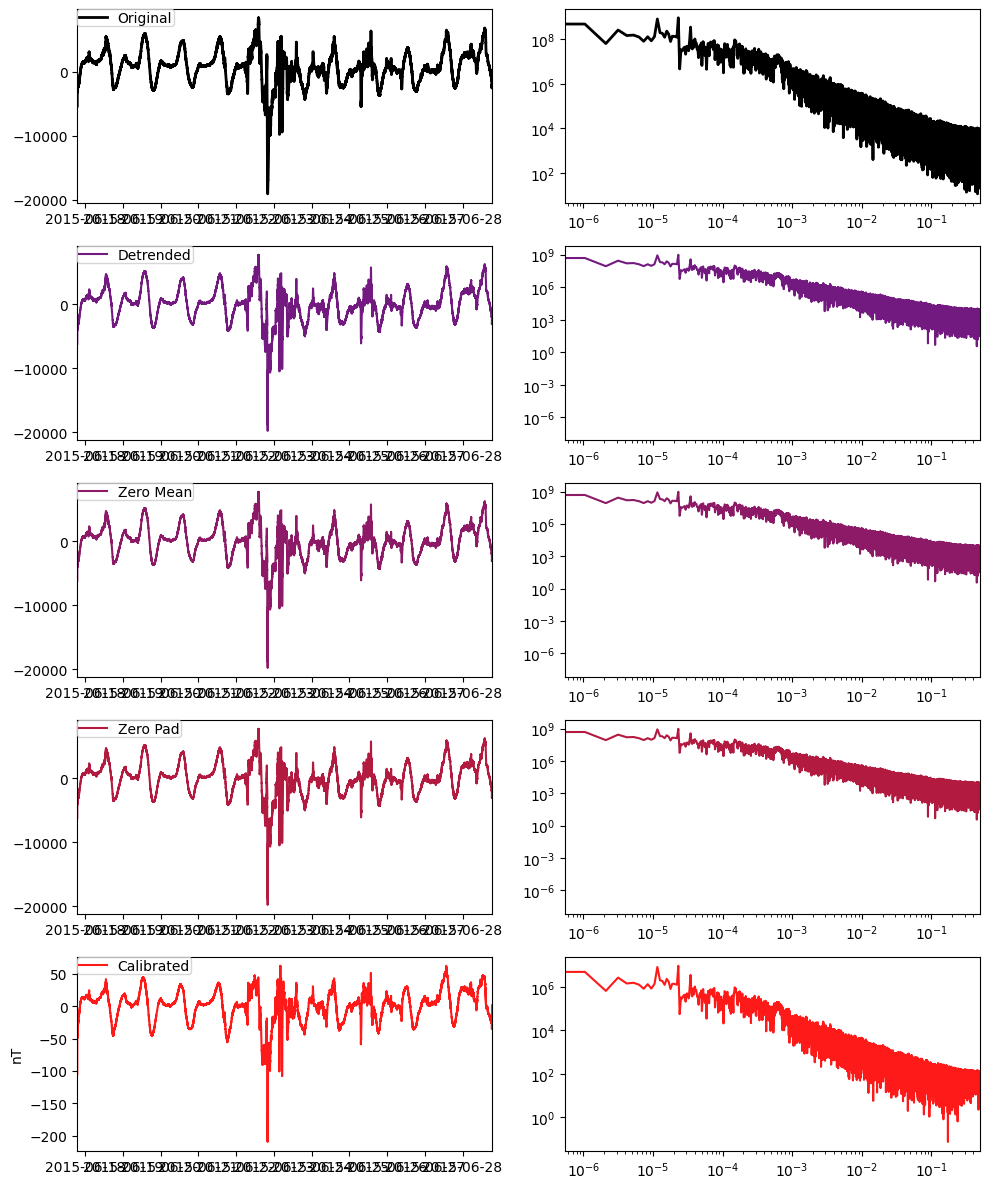

In [38]:
calibrated_hy = hy.remove_instrument_response(plot=True)

In [39]:
# We can suppress the calibrated plot by setting the keyword argument plot=False
calibrated_hz = hz.remove_instrument_response(plot=False)

Note that the mean values are subtracted prior to calibration.  Many magnetometers for magnetotelluric applications are not sensitive to the static "DC" magnetic field, but only sense changes in the field.  However if the magnetometer were a "Fluxgate", as can be seen above under sensor.type, then the DC value is meaningful, and can be added back in.


In [40]:
hy_xrts = calibrated_hy.to_xarray()
hz_xrts = calibrated_hz.to_xarray()


In [41]:
#cond1 = hy_xrts.time >= pd.Timestamp(2015, 6, 22, 1, 45)
#cond2 = hy_xrts.time < pd.Timestamp(2015, 6, 22,2,20)
cond1 = hy_xrts.time >= pd.Timestamp(time_interval_of_interest_start)
cond2 = hy_xrts.time < pd.Timestamp(time_interval_of_interest_end)


<xarray.DataArray 'hy' (time: 2100)>
array([-0.14047066, -0.14633148, -0.16373498, ...,  0.40849415,
        0.37968784,  0.38936805])
Coordinates:
  * time     (time) datetime64[ns] 2015-06-22T01:45:00 ... 2015-06-22T02:19:59
Attributes: (12/25)
    channel_number:             0
    comments:                   run_ids: [g,f,e,d,c,b,a]
    component:                  hy
    data_quality.rating.value:  0
    filter.applied:             [False, False, True]
    filter.name:                ['magnetic_butterworth_low_pass', 'magnetic_a...
    ...                         ...
    time_period.end:            2015-06-28T18:51:24+00:00
    time_period.start:          2015-06-17T19:01:16+00:00
    type:                       magnetic
    units:                      nanotesla
    station.id:                 ALW49
    run.id:                     e


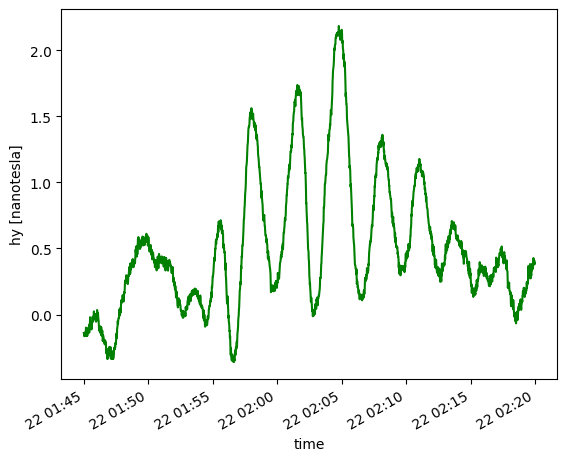

In [42]:
hy_day = hy_xrts.where(cond1 & cond2, drop=True)
print(hy_day)
hy_day.plot(color='g')

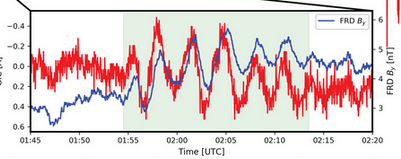

We can see from the above plots that the images are highly similar, but with some differences.  The similarity can be attributed to the fact that the "event" is a large scale geomagnetic phenomena, known to be coherent over 100's of km, whereas the differences can be attributed to instrument variation, spatial variability (the stations are ~1000km apart, and the spatial coherencey at such distance may degrade somewhat).  

## Bandpass Filtering the data

It is often the case the only certain frequency bands of data are desired, for example to remove high frequency spikes, or to suppress long term drift.  The calibration command supports the application of Butterworth band pass filters.  The user must define the "corners" of the band to admit as shown in the following example:

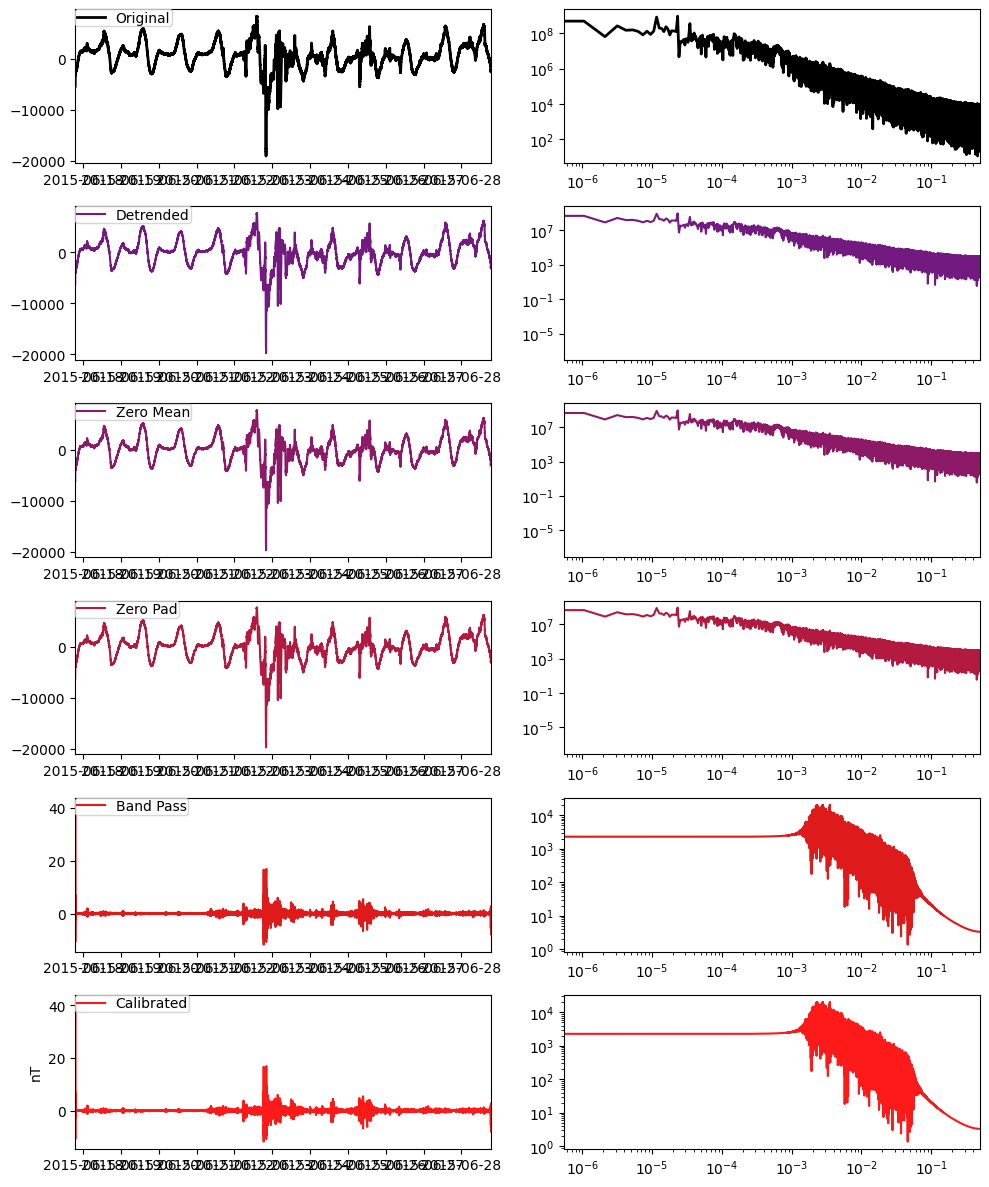

In [43]:
hy = m.from_reference(channel_summary_df.iloc[hy_index].hdf5_reference).to_channel_ts()
calibrated_hy = hy.remove_instrument_response(plot=True, bandpass={"low":0.002, "high":0.05, "order":5})

# 7. Comparison of time series


<xarray.DataArray 'hy' (time: 2100)>
array([-0.14047066, -0.14633148, -0.16373498, ...,  0.40849415,
        0.37968784,  0.38936805])
Coordinates:
  * time     (time) datetime64[ns] 2015-06-22T01:45:00 ... 2015-06-22T02:19:59
Attributes: (12/25)
    channel_number:             0
    comments:                   run_ids: [g,f,e,d,c,b,a]
    component:                  hy
    data_quality.rating.value:  0
    filter.applied:             [False, False, True]
    filter.name:                ['magnetic_butterworth_low_pass', 'magnetic_a...
    ...                         ...
    time_period.end:            2015-06-28T18:51:24+00:00
    time_period.start:          2015-06-17T19:01:16+00:00
    type:                       magnetic
    units:                      nanotesla
    station.id:                 ALW49
    run.id:                     e


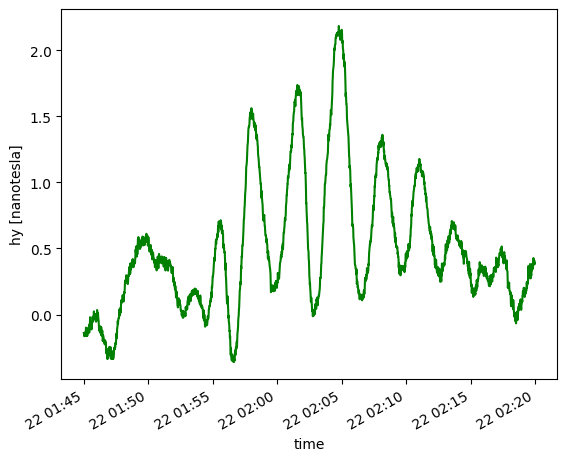

In [44]:
hy_day = hy_xrts.where(cond1 & cond2, drop=True)
print(hy_day)
hy_day.plot(color='g')

# TODO: 9. Access USGS data directly

In [45]:
start = time_interval_of_interest_start
end = time_interval_of_interest_end
#start = "2015-06-22T01:45:00"
#end = "2015-06-22T02:20:00"
usgs_request = {"observatory":"FRD", "type":"adjusted", "elements":["Y",], "sampling_period":1, "start":start,"end":end}
usgs_request_df = pd.DataFrame(data=usgs_request)
usgs_request_df
# maker = MakeMTH5()
maker.from_usgs_geomag?

Signature: maker.from_usgs_geomag(request_df, **kwargs)
Docstring:
Download geomagnetic observatory data from USGS webservices into an
MTH5 using a request dataframe or csv file.

- **observatory**: Geogmangetic observatory ID
- **type**: type of data to get 'adjusted'
- **start**: start date time to request UTC
- **end**: end date time to request UTC
- **elements**: components to get
- **sampling_period**: samples between measurements in seconds

:param request_df: DataFrame with columns

    - 'observatory'     --> Observatory code
    - 'type'            --> data type [ 'variation' | 'adjusted' | 'quasi-definitive' | 'definitive' ]
    - 'elements'        --> Elements to get [D, DIST, DST, E, E-E, E-N, F, G, H, SQ, SV, UK1, UK2, UK3, UK4, X, Y, Z]
    - 'sampling_period' --> sample period [ 1 | 60 | 3600 ]
    - 'start'           --> Start time YYYY-MM-DDThh:mm:ss
    - 'end'             --> End time YYYY-MM-DDThh:mm:ss

:type request_df: :class:`pandas.DataFrame`, str or Path if cs

In [46]:
maker = MakeMTH5()
usgs_h5 = maker.from_usgs_geomag(usgs_request_df)

2024-02-18T09:58:55.763634-0800 | INFO | mth5.mth5 | _initialize_file | Initialized MTH5 0.2.0 file /home/kkappler/software/irismt/aurora/docs/examples/usgs_geomag_FRD_Y.h5 in mode a
2024-02-18T09:58:56.990103-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/aurora/docs/examples/usgs_geomag_FRD_Y.h5
2024-02-18T09:58:56.990711-0800 | WARNING | mth5.mth5 | filename | MTH5 file is not open or has not been created yet. Returning default name


In [47]:
usgs_h5

PosixPath('/home/kkappler/software/irismt/aurora/docs/examples/usgs_geomag_FRD_Y.h5')

In [48]:
m = MTH5()
m.open_mth5(usgs_h5)

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: USGS-GEOMAG
            ---------------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                    |- Group: fap
                    -------------
                    |- Group: fir
                    -------------
                    |- Group: time_delay
                    --------------------
                    |- Group: zpk
                    -------------
                |- Group: Reports
                -----------------
                |- Group: Standards
                -------------------
                    --> Dataset: summary
                    ............

In [49]:
m.channel_summary

        survey         station      run  latitude  longitude  elevation  \
0  USGS-GEOMAG  Fredericksburg  sp1_001    38.205    -77.373       69.0   

  component                     start                       end  n_samples  \
0        hy 2015-06-22 01:45:00+00:00 2015-06-22 02:20:00+00:00       2101   

   sample_rate measurement_type  azimuth  tilt      units  \
0          1.0         magnetic     90.0   0.0  nanotesla   

            hdf5_reference       run_hdf5_reference   station_hdf5_reference  
0  <HDF5 object reference>  <HDF5 object reference>  <HDF5 object reference>  

In [50]:
hy_frd = m.get_channel("Fredericksburg", "sp1_001", "hy", survey="USGS-GEOMAG")

In [51]:
hy_frd_ts = hy_frd.to_channel_ts()

In [52]:
hy_frd_ts.data_array

<xarray.DataArray 'hy' (time: 2101)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2015-06-22T01:45:00 ... 2015-06-22T02:20:00
Attributes: (12/22)
    channel_number:             0
    component:                  hy
    data_quality.rating.value:  0
    filter.applied:             [True]
    filter.name:                []
    hdf5_reference:             <HDF5 object reference>
    ...                         ...
    time_period.end:            2015-06-22T02:20:00+00:00
    time_period.start:          2015-06-22T01:45:00+00:00
    type:                       magnetic
    units:                      nanotesla
    station.id:                 Fredericksburg
    run.id:                     sp1_001

In [53]:
m.close_mth5()

2024-02-18T09:58:57.173948-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/aurora/docs/examples/usgs_geomag_FRD_Y.h5


In [54]:
!rm usgs_geomag_FRD_Y.h5

This is being debugged in issue 188: https://github.com/kujaku11/mth5/issues/188

For now, you can download the data manually here:

https://imag-data.bgs.ac.uk/GIN_V1/GINForms2?observatoryIagaCode=FRD&publicationState=Best+available&dataStartDate=2015-06-22&dataDuration=1&submitValue=View+%2F+Download&request=DataView&samplesPerDay=second

Click the "IAGA-2002" link 

https://imag-data.bgs.ac.uk/GIN_V1/GINServices?Request=GetData&format=Iaga2002&testObsys=0&observatoryIagaCode=FRD&samplesPerDay=second&publicationState=Best%20available&dataStartDate=2015-06-22&dataDuration=1&orientation=native

and you should get a file called "frd20150622vsec.sec"

And then read it in as follows:

In [55]:
iaga_file_basename = "frd20150622vsec.sec"
iaga_file = pathlib.Path().cwd().parent.parent.joinpath("data", "iaga", iaga_file_basename)
if not iaga_file.exists:
    msg = "You need to download the data -- see link in cell above"
    raise FileExistsError(msg)
iaga_df = pd.read_csv(iaga_file, skiprows=21, sep='\s+', parse_dates=[["DATE","TIME"]],)

In [56]:
iaga_df

DATE_TIME  DOY      FRDH  FRDD      FRDZ      FRDF   |
0     2015-06-22 00:00:00  173  21500.58  1.84  45925.05  51315.91 NaN
1     2015-06-22 00:00:01  173  21500.60  1.84  45925.06  51315.93 NaN
2     2015-06-22 00:00:02  173  21500.61  1.85  45925.06  51315.93 NaN
3     2015-06-22 00:00:03  173  21500.60  1.85  45925.07  51315.93 NaN
4     2015-06-22 00:00:04  173  21500.61  1.85  45925.07  51315.96 NaN
...                   ...  ...       ...   ...       ...       ...  ..
86395 2015-06-22 23:59:55  173  21457.32 -5.28  45958.98  51328.53 NaN
86396 2015-06-22 23:59:56  173  21457.31 -5.28  45958.98  51328.53 NaN
86397 2015-06-22 23:59:57  173  21457.25 -5.26  45958.99  51328.48 NaN
86398 2015-06-22 23:59:58  173  21457.15 -5.25  45959.03  51328.45 NaN
86399 2015-06-22 23:59:59  173  21457.10 -5.24  45959.00  51328.43 NaN

[86400 rows x 7 columns]

These data are in HDZ coordinates, but we want XYZ for the comparison.

Y = H*sin(D)

You can read more here: https://wdc.kugi.kyoto-u.ac.jp/element/eleexp.html

Note that the reported D seems to be in minutes _from_ geomagnetic north.

To get geographic coordinates, we would need to know the baseline declination, which
is reported as DEC_BAS in a comment in the IAGA file.  I could not find any clear documentation on how to unpack this number, but instead looked up the declination at Fredricksburg VA online
[https://www.magnetic-declination.com/USA/FREDERICKSBURG/2859148.html] and see it is -10.25 degrees.

Of course to be very precise one should correct the declination for time, as these observations were from 2015 when a different World Magnetic Model was active.

The bezpy package works in geomagnetic coordinates: https://github.com/greglucas/bezpy/tree/main

In [57]:
#+12.78° (13°46')
Y = iaga_df.FRDD
DECLINATION_DEG = -10.25
DECLINATION_RAD = np.deg2rad(DECLINATION_DEG)

MIN_ARC_to_RAD = 0.000290888 #(deg2rad(1/60))
D_to_RAD = MIN_ARC_to_RAD

In [58]:
#Here is what Bezpy does -- which corresponds to a magnetic coordinate system
iaga_df["X_bezpy"] = np.cos(np.deg2rad(iaga_df.FRDD/60.)) * iaga_df.FRDH
iaga_df["Y_bezpy"] = np.sin(np.deg2rad(iaga_df.FRDD/60.)) * iaga_df.FRDH

# While this corresponds to a geographic coordinate system
iaga_df["X"] = np.cos(DECLINATION_RAD + iaga_df.FRDD*D_to_RAD) * iaga_df.FRDH
iaga_df["Y"] = np.sin(DECLINATION_RAD + iaga_df.FRDD*D_to_RAD) * iaga_df.FRDH

These are very similar in variation, but quite different in mean value:

In [59]:
import matplotlib.pyplot as plt
import scipy.signal as ssig

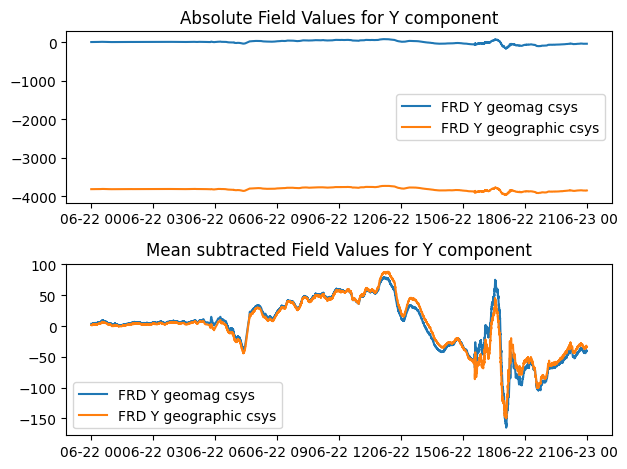

In [60]:
fig, ax = plt.subplots(2,1)
ax[0].plot(iaga_df.DATE_TIME, iaga_df.Y_bezpy, label="FRD Y geomag csys")
ax[0].plot(iaga_df.DATE_TIME, iaga_df.Y, label="FRD Y geographic csys")
ax[0].legend()
ax[1].plot(iaga_df.DATE_TIME, ssig.detrend(iaga_df.Y_bezpy,type="constant"), label="FRD Y geomag csys")
ax[1].plot(iaga_df.DATE_TIME, ssig.detrend(iaga_df.Y,type="constant"), label="FRD Y geographic csys")
ax[1].legend()
ax[0].set_title("Absolute Field Values for Y component")
ax[1].set_title("Mean subtracted Field Values for Y component")
fig.tight_layout()

In [61]:
cond1 = iaga_df.DATE_TIME >= time_interval_of_interest_start
cond2 = iaga_df.DATE_TIME < time_interval_of_interest_end
sub_df = iaga_df[cond1&cond2]
print(len(sub_df))

2100


Text(0, 0.5, 'nanoTesla')

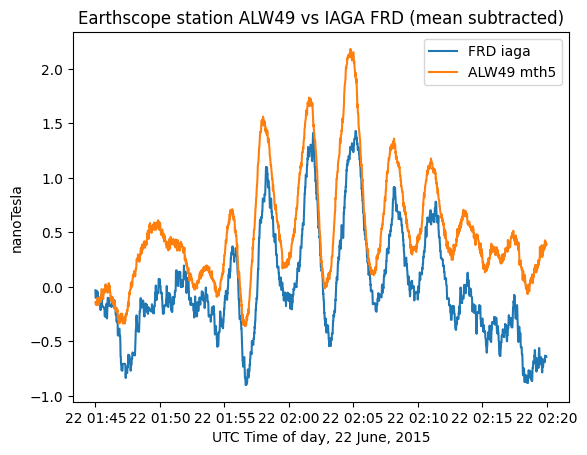

In [62]:
fig, ax = plt.subplots(1)
ax.plot(sub_df.DATE_TIME, ssig.detrend(sub_df.Y), label="FRD iaga")
ax.plot(sub_df.DATE_TIME, hy_day.data, label="ALW49 mth5")
ax.legend()
ax.set_xlabel("UTC Time of day, 22 June, 2015")
ax.set_title("Earthscope station ALW49 vs IAGA FRD (mean subtracted)")
ax.set_ylabel("nanoTesla")

In the above plot we can see that the data are highly similar but not identical.  Understanding the differences in the observed fields at the different stations and relating them to a model is a topic of ongoing investigation.

**Future Work** 

[ ] 1. Add an automated check warning the user when unknown filter units are encountered.
- Added some text around cell 33 warning the user about this.
- If filters are unknown is there a contact at EarthScope to request the info?
- The "enrich_dataframe" method from aurora (used in widescale tests) could be added to MTH5 for this